In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os  
import re
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import matplotlib.animation as animation
import matplotlib.cm as cm

In [3]:
# helper functions
def str_to_timedelta(date_str):
    date_dt = pd.to_datetime(date_str, format='%H:%M:%S')
    date_td = timedelta(hours=date_dt.hour, minutes=date_dt.minute, seconds=date_dt.second)
    return date_td

def read_file(file_name, time_col):
    try:
        current_df = pd.read_csv('data/' + file_name, parse_dates=[time_col], date_parser=lambda x: str_to_timedelta(x))
        date_str = re.search("([0-9]{4}\-[0-9]{2}\-[0-9]{2})", file_name)
        date_dt = datetime.strptime(date_str.group(1), '%Y-%m-%d')
        current_df['Date'] = date_dt
        current_df['DateTime'] = current_df[time_col] + current_df['Date']
        current_df.drop([time_col, 'Date'], axis=1, inplace=True)
        return current_df
    except:
        print('Unable to load file: {}'.format(file_name))
        

In [4]:
files = os.listdir('data/')
station_locations = pd.read_csv('station_locations.csv')

In [5]:
# load the files into DataFrames
weather_df = pd.concat([read_file(file, 'Time') for file in files if file.startswith('weather')], sort=False)
weather_df.sort_values('DateTime', inplace=True)
weather_df.reset_index(drop=True, inplace=True)

bikes_df = pd.concat([read_file(file, 'Unnamed: 0') for file in files if file.startswith('bikes')], sort=False)
bikes_df.sort_values('DateTime', inplace=True)
bikes_df.reset_index(drop=True, inplace=True)

Unable to load file: bikes_300715_to_070815.csv


There are some issues with this data so we will need to do some preprocessing to clean it up. 

The data was collected at ~2 minute intervals but there were many bigger intervals and I need these intervals to be somewhat consistent for our analysis. I will find the longest streak such that the interval between successive data points does not exceed 10 minutes and use this to continue my analysis. 

In [6]:
# Series of differences between each observation and its previous
difference_to_previous = bikes_df['DateTime'] - bikes_df['DateTime'].shift(1)
long_interval_values = difference_to_previous[difference_to_previous > '00:10:00']
long_interval_index = pd.Series(long_interval_values.index)
print('\n\nNumber of long intervals between observations: {}'.format(len(long_interval_index)))

# find the longest run of observations without any gaps > 10 mins
interval_lengths = long_interval_index - long_interval_index.shift(1)
longest_interval = interval_lengths.max()

# and work back to find the indices of this long run in the original data
index = interval_lengths[interval_lengths==longest_interval].index[0]
interval_lengths[interval_lengths.index == index]

start_index = long_interval_index[long_interval_index.index == index-1].iloc[0]
end_index = long_interval_index[long_interval_index.index == index].iloc[0] - 1
print('Number of sequential observations with time intervals < 10 mins: {}\n'.format(end_index - start_index))



Number of long intervals between observations: 31
Number of sequential observations with time intervals < 10 mins: 26857



In [7]:
bikes_df_reduced = bikes_df.iloc[start_index:end_index,:].reset_index(drop=True)
weather_df_reduced = weather_df.iloc[start_index:end_index,:].reset_index(drop=True)

# remove last day containing only 8 hrs of data
bikes_df_reduced = bikes_df_reduced[(bikes_df_reduced['DateTime'] < '2017-05-27') & (bikes_df_reduced['DateTime'] >= '2017-04-21')]
weather_df_reduced = weather_df_reduced[(weather_df_reduced['DateTime'] < '2017-05-27') & (weather_df_reduced['DateTime'] >= '2017-04-21')]

reduced_differences = bikes_df_reduced['DateTime'] - bikes_df_reduced['DateTime'].shift(1)
avg_interval = np.round(reduced_differences.mean().total_seconds()/60, 3)
print('\n\nAverage interval between observations in reduced data is: {} minutes,'.format(avg_interval))
start_date = bikes_df_reduced['DateTime'].iloc[0]
end_date = bikes_df_reduced['DateTime'].iloc[-1] 
sequence_length = end_date - start_date
sequence_length = np.round(sequence_length.total_seconds()/(60*60*24))
print('and the length of this reduced sequence is ~{} days from {} to {}.\n'.format(sequence_length, start_date.date(), end_date.date()))

# finally merge the two datasets
full_data = pd.merge(bikes_df_reduced, weather_df_reduced, on='DateTime')



Average interval between observations in reduced data is: 2.003 minutes,
and the length of this reduced sequence is ~36.0 days from 2017-04-21 to 2017-05-26.



In [8]:
# now to deal with observations in the data
cols_with_nans = list(full_data.columns[full_data.isnull().any().values])
print('\n\nProportion of missing values for each column:')
full_data[cols_with_nans].isnull().mean()



Proportion of missing values for each column:


CHATHAM_STREET    0.444543
CLARENDON_ROW     0.555457
dtype: float64

It seemed like too much of a coincidence that CHATHAM_STREET and CLARENDON_ROW were never *both* similtaniously missing. 

A quick google revealed that on May 2nd 2017 Chatham Street bike station relocated to Clarendon Row. Thus it makes sense to combine the two columns into one single station.

In [9]:
full_data['CHATHAM_STREET/CLARENDON_ROW'] = full_data[cols_with_nans].sum(axis=1).astype('int64')
full_data.drop(cols_with_nans, axis=1, inplace=True)

In [10]:
# finally we need to deal with some missing data and tidy the timestamps

# the Wind_Speed column is a mix of strings and ints so we will drop
full_data.drop('Wind_Speed', axis=1, inplace=True)

# we also will deal with the slightly inconsistent timestamps leading to missing data
missing_vals = 720 - full_data['DateTime'].dt.date.value_counts().sort_values()
print('Number of missing values per day:')
display(pd.DataFrame(missing_vals))

Number of missing values per day:


,DateTime
2017-05-09,7
2017-05-04,6
2017-05-17,3
2017-05-26,3
2017-05-24,3
2017-05-22,3
2017-05-01,3
2017-05-05,3
2017-05-03,2
2017-05-16,1


In [11]:
# we will fill any missing observation by a rolling median of window size 1

days_incomplete = missing_vals[missing_vals > 0]
days_complete_df = full_data[~full_data['DateTime'].dt.date.isin(days_incomplete.index)]

days_incomplete_list = []
for date, n in days_incomplete.items():
    current_df = full_data[full_data['DateTime'].dt.date == date]
    differences = current_df['DateTime'] - current_df['DateTime'].shift(1)
    idx = differences.sort_values(ascending=False)[:n].index
    for index in idx.values:
        new_idx = ((index-1)+index)/2
        new_row = pd.Series(name=new_idx)
        current_df = current_df.append(new_row)
    current_df = current_df.sort_index().reset_index(drop=True)
    current_df['Weather'].fillna(method='ffill', inplace=True)
    current_df['DateTime'].fillna(method='ffill', inplace=True)
    current_df = current_df.apply(lambda x: x.interpolate().round() if x.name not in  ['DateTime', 'Weather'] else x)
    days_incomplete_list.append(current_df)
    
days_incomplete_df = pd.concat(days_incomplete_list)

In [12]:
# finally ensure that the observations are evenly spaced
full_data = pd.concat([days_complete_df, days_incomplete_df])
full_data.sort_values(by='DateTime', inplace=True)
new_datetimes = pd.date_range(start='2017-04-21', end='2017-05-27', freq='2min', closed='left')
full_data['DateTime'] = new_datetimes
full_data.reset_index(drop=True, inplace=True)

Since bikes are probably coming in and out of the general population (damage to bike, vandalism etc.) the total number of bikes ($Total\ bikes$) is constantly changing. 
I have considered a number of approaches for estimating the number of active bikes at any given time, but none are perfect. The simplest approach is to assume that maximum number of avaiable bikes observed over the entire data is the total number of available bikes, and then calculating:

$$Total\ bikes = available\ bikes + active\ bikes$$

Alternatively we could calculate the maximum available bikes over windows (e.g. days) across the data. This probably gives a more accurate estimate but leads to sudden jumps/drops between windows which would damage future analyses. Thus I have decided to procede with the former approcah (although the second approach is also implemented and commented out below). 

In [13]:
# we will try to get an idea of the total amount of bikes in stations/in use accross the city at any given time
station_columns = [column_name for column_name in list(full_data.columns) if column_name.isupper()]
station_columns.sort()

# avaiable bikes (bikes in stations) is straight forward to calculate
full_data['available_bikes'] = full_data[station_columns].sum(axis=1)

In [14]:
# # we don't know the total number of bikes in circulation at any given time
# # so we can only estimate the number of bikes in use 
# # we will estimate this based on the maximum number of bikes available each day
# max_available = full_data[['DateTime', 'available_bikes']].resample('D', on='DateTime').max()
# max_available.drop('DateTime', axis=1, inplace=True)
# max_available.reset_index(inplace=True)
# max_available.rename(columns={'available_bikes':'max_available'}, inplace=True)
# max_available['DateTime'] = max_available['DateTime'].dt.date
# stored_date_times = full_data['DateTime']
# full_data['DateTime'] = full_data['DateTime'].dt.date
# active_bikes_df = pd.merge(full_data[['DateTime', 'available_bikes']], max_available, on='DateTime')
# full_data['DateTime'] = stored_date_times
# active_bikes = active_bikes_df['max_available'] - active_bikes_df['available_bikes']
# full_data['active_bikes'] = active_bikes

In [15]:
full_data['total_bikes'] = full_data['available_bikes'].max()
full_data['active_bikes'] = full_data['total_bikes'] - full_data['available_bikes']

Finally, lets start taking a look at the actual data

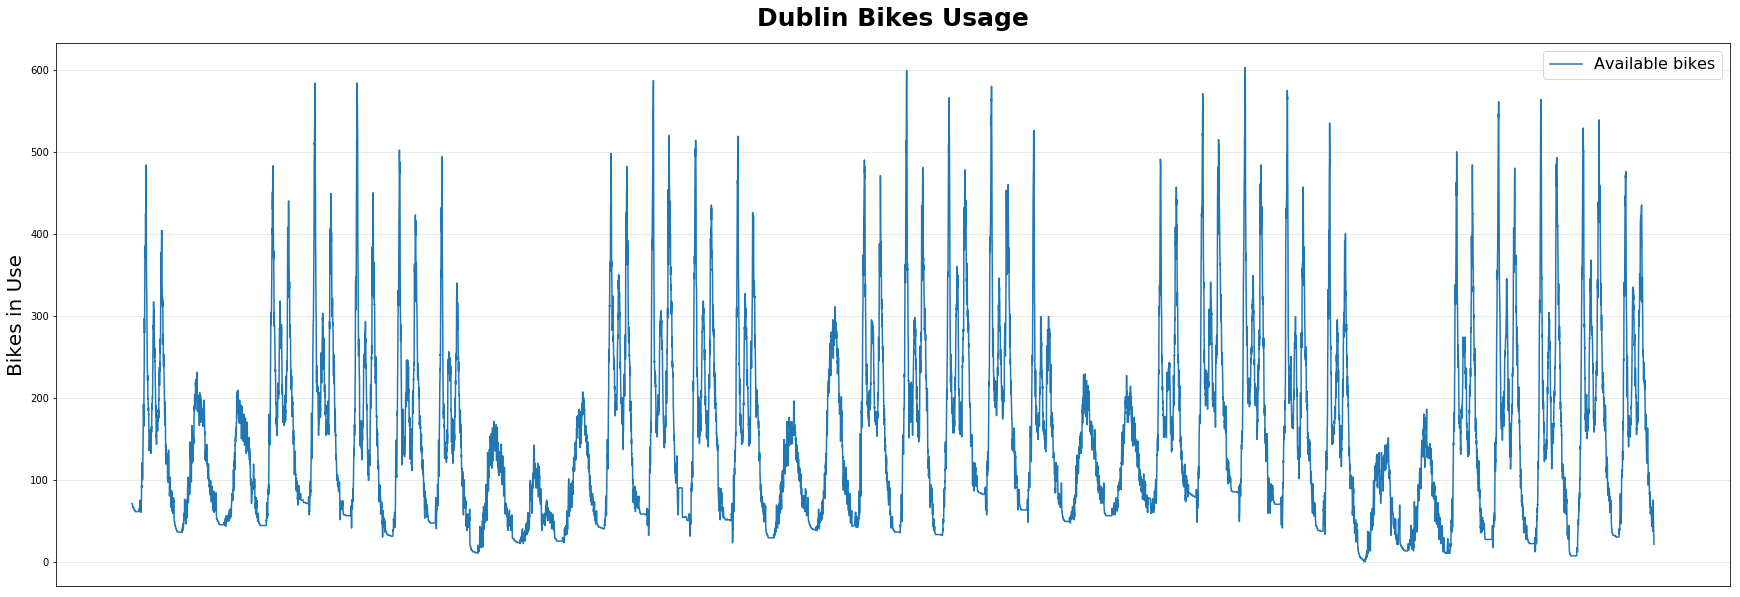

In [16]:
# plot the full data
data_to_plot = full_data['active_bikes']
x_labs = full_data[['DateTime']]

fig, ax = plt.subplots(figsize=(30,10))
data_to_plot.plot(ax=ax)
plt.title('Dublin Bikes Usage', y=1.02, fontsize=25, fontweight="bold")
ax.legend(loc='upper right', frameon=True).get_frame().set_edgecolor('grey')
ax.legend(fontsize=16).get_texts()[0].set_text('Available bikes')
ax.set_ylabel('Bikes in Use', fontsize=20)
plt.xticks([])
plt.grid(alpha=0.35, axis='y')
plt.plot();


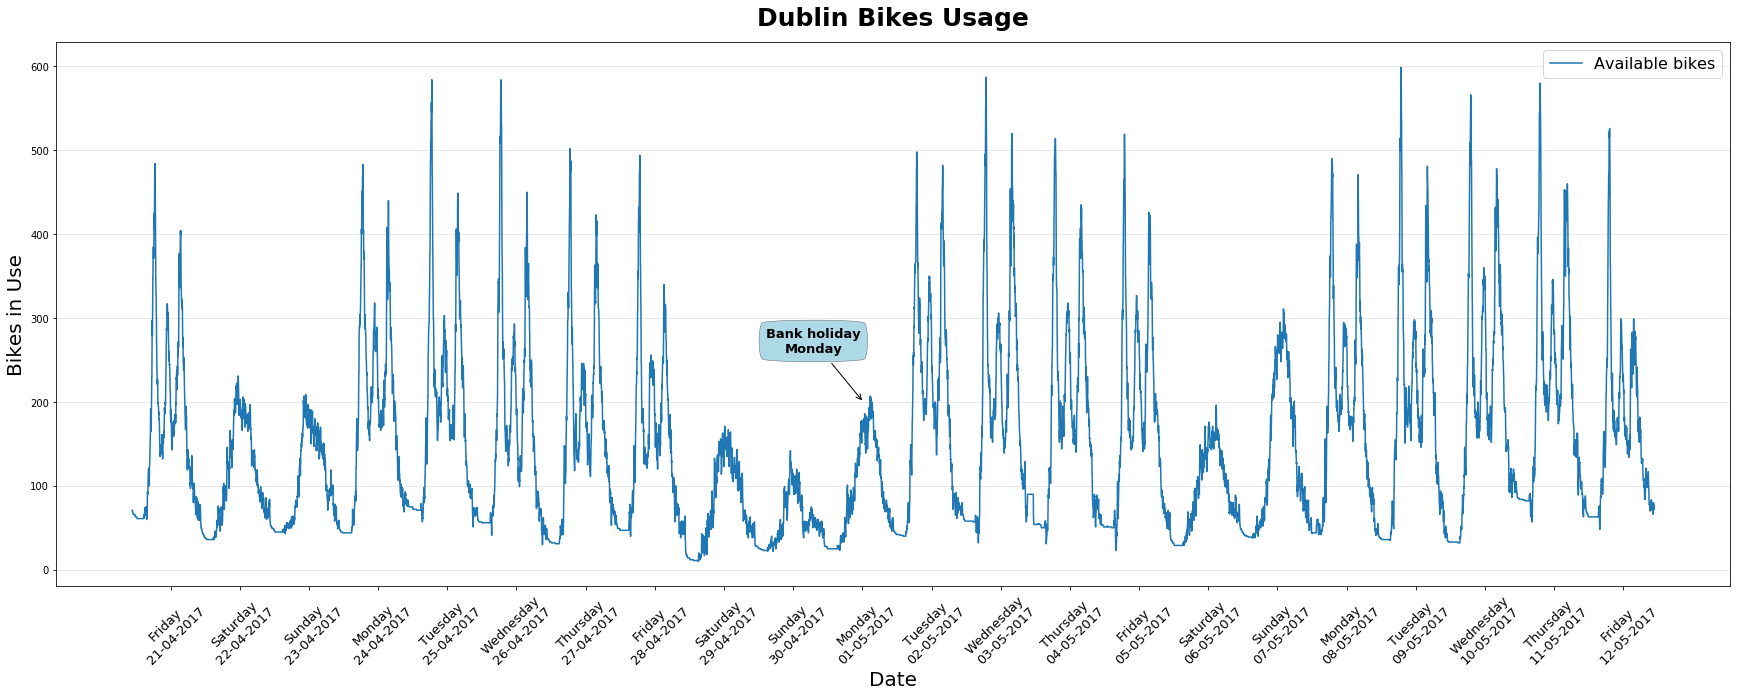

In [17]:
# now plot a sample of the data for use in the report
data_to_plot = full_data['active_bikes'][-27500:-10100]
x_labs = full_data[['DateTime']][-27500:-10100]

fig, ax = plt.subplots(figsize=(30,10))
data_to_plot.plot(ax=ax)
plt.title('Dublin Bikes Usage', y=1.02, fontsize=25, fontweight="bold")
ax.legend(loc='upper right', frameon=True).get_frame().set_edgecolor('grey')
ax.legend(fontsize=16).get_texts()[0].set_text('Available bikes')
ax.set_ylabel('Bikes in Use', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
formatted_x_labs = ['{}\n{}'.format(timestamp.strftime('%A'), timestamp.strftime('%d-%m-%Y')) for timestamp in x_labs['DateTime']]
num_days = len(set(formatted_x_labs))
nth_label = (len(data_to_plot)//(num_days)) 
plt.xticks(data_to_plot.index[400::nth_label], formatted_x_labs[400::nth_label], rotation=45, fontsize=13)
plt.grid(alpha=0.35, axis='y')
bbox_props = {'boxstyle':"round4, pad=0.6", 'fc':"lightblue", 'ec':"dimgrey", 'lw':.5}
ax.annotate('Bank holiday\nMonday',
            fontsize=13,
            fontweight='heavy',
            ha='center',
            xy=(7600, 200),  
            xycoords='data',
            xytext=(-50, 50),      
            textcoords='offset points',
            arrowprops={'arrowstyle':'->'}, bbox=bbox_props) 
plt.savefig('visualisations/dublin_bikes_usage.png', bbox_inches='tight')
plt.plot();


In [21]:
station_locations['Name'] = station_locations['Name'].apply(lambda x: x.replace(' ', '_'))
station_locations.loc[station_locations['Name']=='CHATHAM_STREET','Name'] = 'CHATHAM_STREET/CLARENDON_ROW'

Lets visualise the capacity at each of the stations at a given time of the day

In [22]:
# lets visualise a typical weekday vs holiday
# full_data = full_data.reindex(sorted(full_data.columns), axis=1)
weekday = full_data[full_data['DateTime'].dt.date == datetime(2017, 4, 25).date()]
holiday = full_data[full_data['DateTime'].dt.date == datetime(2017, 4, 22).date()]
weekday.set_index('DateTime', inplace=True)
holiday.set_index('DateTime', inplace=True)

# calculate the proportion of fullness of each station on these days 
max_bikes_per_station = full_data[station_columns].transpose().max(axis=1)
weekday_prop = weekday[station_columns].div(max_bikes_per_station)
holiday_prop = holiday[station_columns].div(max_bikes_per_station)

# sort station locations to match 
station_locations.sort_values(by=['Name'], inplace=True)


In [23]:
lat_max = station_locations['Latitude'].max() + 0.001
lat_min = station_locations['Latitude'].min() - 0.001
lon_max = station_locations['Longitude'].max() + 0.001
lon_min = station_locations['Longitude'].min() - 0.001 

In [24]:
%%capture
fig, ax = plt.subplots(figsize=(20,10))

# generate basemap
bmap = Basemap(epsg=3857, llcrnrlon=lon_min, llcrnrlat=lat_min,
          urcrnrlon=lon_max, urcrnrlat=lat_max, ax=ax, resolution='c') 
bmap.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 500, verbose= True)

# generate fixed colorbar
norm= cm.colors.Normalize(vmin=0, vmax=1, clip=False)
SM = cm.ScalarMappable(norm=norm, cmap='bwr')
SM.set_array([])
cbar = fig.colorbar(SM, ax=ax)
cbar.set_label("Station Capacity", rotation=270, labelpad=-10, fontsize=20, weight='semibold')
cbar.set_ticks([0,1])
cbar.set_ticklabels(['Empty','Full'])

In [25]:
# lets pick a random observation from the data
current_row = weekday_prop.iloc[260,:]
day = current_row.name.day_name()
date = current_row.name.strftime("%d-%m-%Y")
time = current_row.name.strftime("%H:%M")
readable_datetime = '{}\n{}\n{}'.format(day, date, time)

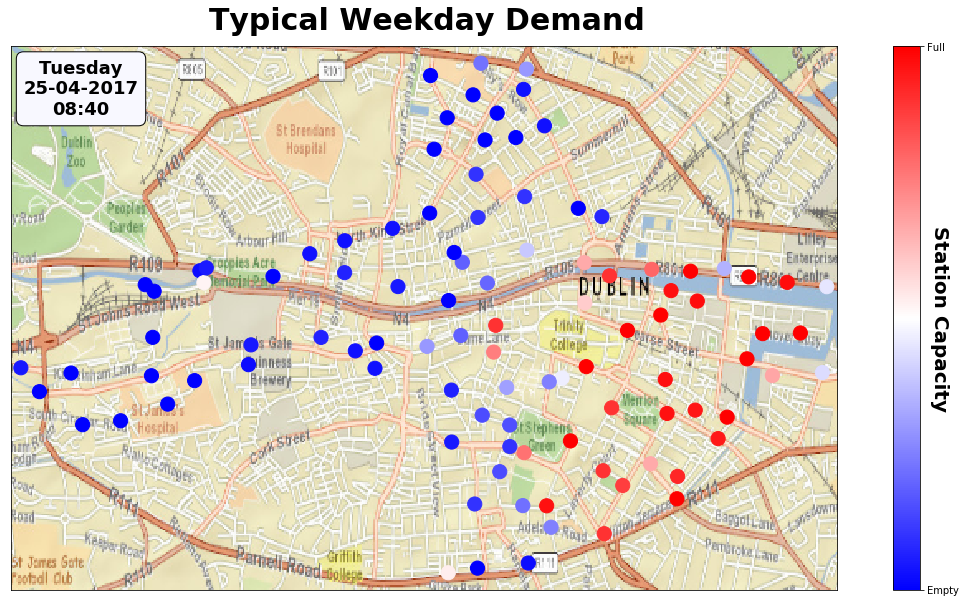

In [26]:
# and finally lets plot 
x = list(station_locations['Longitude'])
y = list(station_locations['Latitude'])
x, y = bmap(x, y) 
plot = bmap.scatter(x, y, s=200, marker='o', c=current_row.values, cmap='bwr')
fig.text(x=0.22, y=0.785, s=readable_datetime, 
         horizontalalignment='center',
         fontdict = {'color':  'black', 'weight': 'semibold','size': 18},
         bbox=dict(facecolor='ghostwhite', boxstyle='round', pad=0.4))
fig.suptitle('Typical Weekday Demand', fontsize=30, x=0.46, y=0.935, weight='bold')
fig

Lets turn this into a timelapse gif over an entire day 

In [27]:
current_row = weekday_prop.iloc[150,:]  # start at 5am
day = current_row.name.day_name()
date = current_row.name.strftime("%d-%m-%Y")
time = current_row.name.strftime("%H:%M")
readable_datetime = '{}\n{}\n{}'.format(day, date, time)

In [28]:
%%capture
fig, ax = plt.subplots(figsize=(20,10))

# generate basemap
bmap = Basemap(epsg=3857, llcrnrlon=lon_min, llcrnrlat=lat_min,
          urcrnrlon=lon_max, urcrnrlat=lat_max, ax=ax, resolution='c') 
bmap.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1400, verbose= True)

# generate fixed colorbar
norm= cm.colors.Normalize(vmin=0, vmax=1, clip=False)
SM = cm.ScalarMappable(norm=norm, cmap='bwr')
SM.set_array([])
cbar = fig.colorbar(SM, ax=ax)
cbar.set_label("Station Capacity", rotation=270, labelpad=-10, fontsize=20, weight='semibold')
cbar.set_ticks([0,1])
cbar.set_ticklabels(['Empty','Full'])

# initial fig parameters
fig.suptitle('Typical Weekday Demand', fontsize=30, x=0.46, y=0.935, weight='bold')
fig.text(x=0.22, y=0.785, s=readable_datetime, 
         horizontalalignment='center',
         fontdict = {'color':  'black', 'weight': 'semibold','size': 18},
         bbox=dict(facecolor='ghostwhite', boxstyle='round', pad=0.4))

In [33]:
x = list(station_locations['Longitude'])
y = list(station_locations['Latitude'])


x, y = bmap(x, y) 
plot = bmap.scatter(x, y, s=200, marker='o', c=current_row.values, cmap='bwr')

# initialise plot
def init():
    return plot,

# run through time
def animate(i):
    index = 150 + i*5  # every 10 minutes beginnning at 5am
    current_row = weekday_prop.iloc[index,:]
    plot = bmap.scatter(x, y, s=200, marker='o', c=current_row.values, cmap='bwr')
    time = current_row.name.strftime("%H:%M")
    readable_datetime = '{}\n{}\n{}'.format(day, date, time)
    fig.text(x=0.22, y=0.785, s=readable_datetime, 
         horizontalalignment='center',
         fontdict = {'color':  'black', 'weight': 'semibold','size': 18},
         bbox=dict(facecolor='ghostwhite', boxstyle='round', pad=0.4))
    return plot,

# call the animator and save as gif
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=114, interval=500, blit=True)

anim.save('visualisations/weekday_demand.gif', writer='imagemagick', fps=4, savefig_kwargs={
    'bbox_inches':'tight', 'pad_inches':0})

# to watch inline

# from IPython.display import HTML
# HTML(anim.to_jshtml())

In [57]:
# number of frames in gif
(weekday_prop.shape[0] - 150)/5

114.0

In [ ]:
full_data.to_csv('full_data.csv', index=False)